In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from enum import Enum

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/ankitesg/data/CESM2_f19_v13_updated_NN_pelayout01_ens_07.cam.h1.2003-01-22-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
DATA_DIR = '/DFS-L/DATA/pritchard/ankitesg/datav3/'
hyam = coor.hyam
hybm = coor.hybm
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']

In [3]:
class dataType(Enum):
    ALL = 0
    ALL_RH = 1
    REDUCED_INP_DIM = 2
    REMOVED_INP_LIQ_ICE = 3
    REDUCED_OUT_DIM = 4

In [9]:
class DataGeneratorClimInvRealGeo(DataGenerator):

    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train', exp=None,data_type=dataType.ALL.value):
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.exp = exp
        self.mode=mode
        self.data_type = data_type
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        self.new_idx = np.concatenate((self.input_idxs[8:26],self.input_idxs[34:52],self.input_idxs[60:78],self.input_idxs[86:104],\
        self.input_idxs[104:]))
        self.new_idx = np.concatenate((np.arange(8,26),np.arange(34,52),np.arange(60,78),np.arange(86,104),np.arange(104,108)))
        self.new_output_idx = np.concatenate((np.arange(8,26),np.arange(26,52),np.arange(60,78),np.arange(86,104),np.arange(104,112)))

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
#         print(self.new_idx)
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        if self.data_type == dataType.REDUCED_INP_DIM.value:
            return X_norm[:,self.new_idx], Y
        if self.data_type == dataType.REDUCED_OUT_DIM.value:
            return X_norm[:,self.new_idx], Y[:,self.new_output_idx]
        
        
        return X_norm,Y
    
    
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm

        if self.exp:
            if self.exp['LHFLX']:
                if self.lhflx_trans:
                    X_result = self.lhflxLayer.process(X_result)
                    X_result = X_result[:,:64]
                    X = X[:,:64]

                if self.rh_trans:
                    X_result = self.qv2rhLayer.process(X_result)
                    
                
               
                if self.t2tns_trans:
                    X_result = self.t2tnsLayer.process(X_result)
                    
            else:
                if self.rh_trans:
                    X_result = self.qv2rhLayer.process(X_result) 
                
                
               
                if self.t2tns_trans:
                    X_result = self.t2tnsLayer.process(X_result)
                    
                if self.lhflx_trans:
                    X_result = self.lhflxLayer.process(X_result)
                    X_result = X_result[:,:64]
                    X = X[:,:64]


        else:
            if self.rh_trans:
                X_result = self.qv2rhLayer.process(X_result)
            
               
            if self.t2tns_trans:
                X_result = self.t2tnsLayer.process_V1(X_result)
                
            if self.lhflx_trans:
                X_result = self.lhflxLayer.process_V1(X_result)
                X_result = X_result[:,:64]
                X = X[:,:64]


        if self.scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))

        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))

        if self.data_type == dataType.REDUCED_INP_DIM.value:
            return X_result[:,self.new_idx], Y
        if self.data_type == dataType.REDUCED_OUT_DIM.value:
            return X_result[:,self.new_idx], Y[:,self.new_output_idx]
        
        
        return X_result,Y
    


In [10]:
config_file = ['CI_RG_M4K_CONFIG.yml','CI_RG_M4K_CONFIG2.yml'] # Configuration file
data_file = ['RG_SP_M4K_valid.nc']  # Validation/test data sets
NNarray = ['BF_RG_TrimV1.h5'] # NN to evaluate 
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
NNname = ['BF_TrimV1(Reduced Input Dimensions)', 'BF_TrimV2(Reduced Output Dimensions)'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}
all_data_types = [dataType.REDUCED_INP_DIM.value, dataType.REDUCED_OUT_DIM.value]

In [11]:
# Indices of different variables
PHQ_idx = slice(0,26)
TPHYSTND_idx = slice(26,52)

In [12]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    model = path
    exp=None

    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file[i],
                                     '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=None, inp_divRH=None,
                                     inp_subTNS=None,inp_divTNS=None,
                                     model=model,exp=exp,data_type=all_data_types[i])
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file[i],
                                                '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                              nlat=96,nlon=144,nlev=26)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  BF_RG_TrimV1.h5
data name is  RG_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:1155: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [13]:
# mdx =  md['BF_RGV4.h5'][data_file[0][6:-3]] 
# mdx.compute_stats_random(niter=200)
for nn in NNarray:
    mdx = md[nn][data_file[0][6:-3]]
    mdx.compute_stats_random(niter=200)
    md[nn][data_file[0][6:-3]] = mdx

/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:180: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [14]:
in_vars = ['QBP','TBP','CLDLIQBP','CLDICEBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND', 'CLDICEBCTEND', 'NN2L_FLWDS', 'NN2L_PRECC', 
            'NN2L_PRECSC', 'NN2L_SOLL', 'NN2L_SOLLD', 'NN2L_SOLS', 'NN2L_SOLSD', 'NN2L_NETSW']
tendencies = out_vars[:4]
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']
fd = [scale_dict]

BF_RG_TrimV1.h5


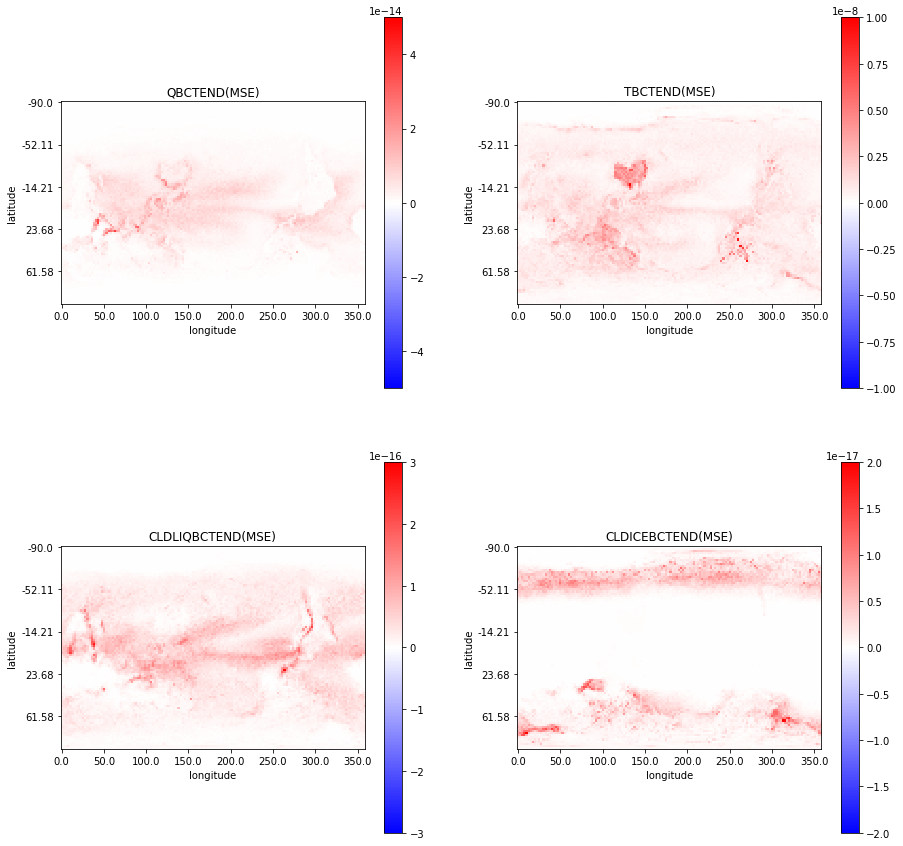

In [15]:
for nn in NNarray:
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,2,figsize=(15, 15))
    axarr = axarr.flatten()
    vmins = [-5e-14,-1e-8,-3e-16,-2e-17]
    vmaxs = [5e-14,1e-8,3e-16,2e-17]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow(mdx.stats['mse'][:,:,(i+1)*25],cmap=plt.cm.bwr,vmin=vmins[i],vmax=vmaxs[i])
        axarr[i].set_xlabel("longitude")
        axarr[i].set_ylabel("latitude")
        axarr[i].set_title(f"{t}(MSE)")
        axarr[i].set_xticks(np.arange(0,141,20))
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticklabels(x_ticks)
        axarr[i].set_yticks(np.arange(0,81,20))
        axarr[i].set_yticklabels(y_ticks)
    plt.show()

BF_RG_TrimV1.h5


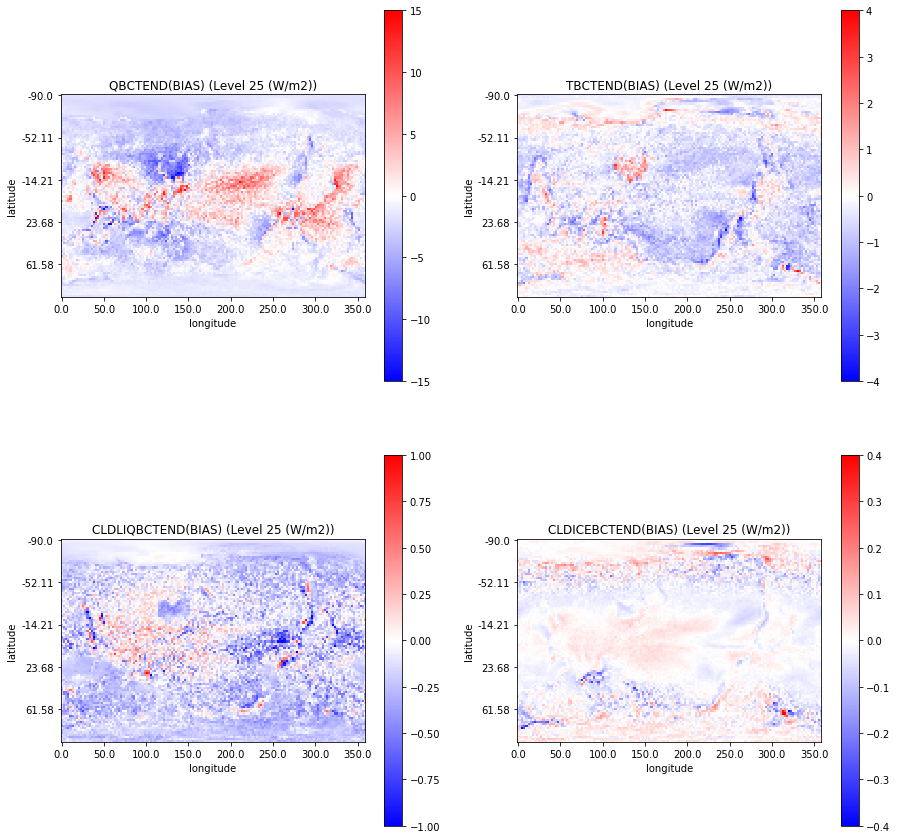

In [16]:
for j, nn in enumerate(NNarray):
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,2,figsize=(15, 15))
    axarr = axarr.flatten()
#     vmins = [-1.0e-7,-0.00003,-4e-9,-1.5e-9]
#     vmaxs = [1.0e-7,0.00003,4e-9,1.5e-9]
    vmins = [-15,-4,-1,-0.4]
    vmaxs = [15,4,1,0.4]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow(mdx.stats['bias'][:,:,(i+1)*25]*fd[j][t][-1],cmap=plt.cm.bwr,vmin=vmins[i],vmax=vmaxs[i])
        axarr[i].set_xlabel("longitude")
        axarr[i].set_ylabel("latitude")
        axarr[i].set_title(f"{t}(BIAS) (Level 25 (W/m2))")
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticks(np.arange(0,141,20))
        axarr[i].set_xticklabels(x_ticks)
        axarr[i].set_yticks(np.arange(0,81,20))
        axarr[i].set_yticklabels(y_ticks)
    plt.show()


BF_RG_TrimV1.h5


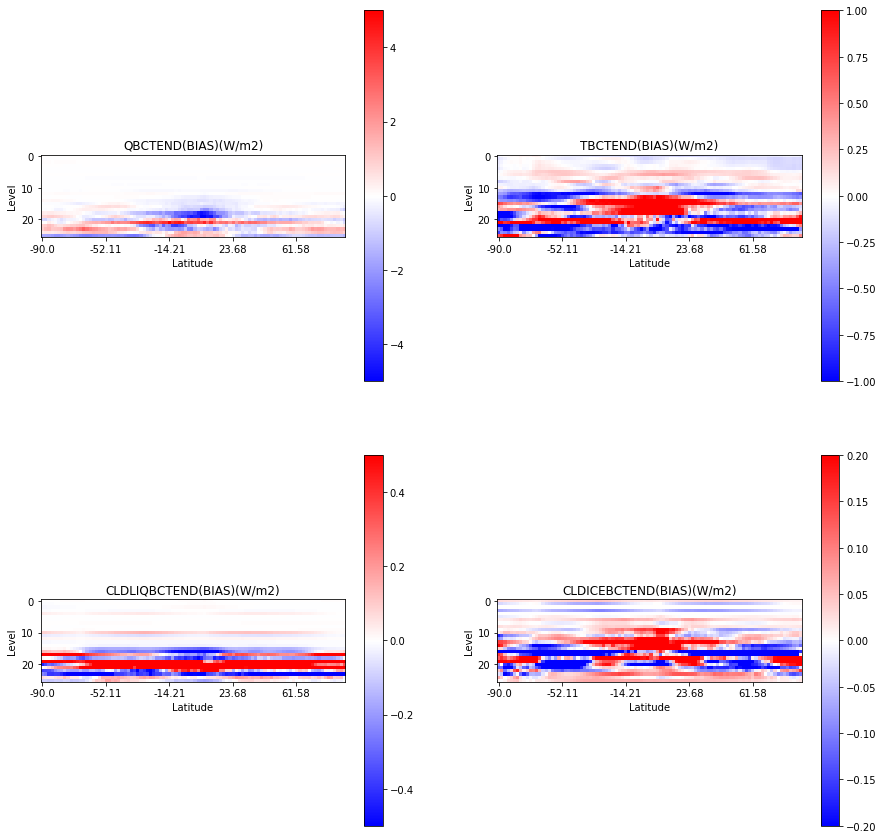

In [17]:
for j, nn in enumerate(NNarray):
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,2,figsize=(15, 15))
    axarr = axarr.flatten()
    lon_mean = np.mean(mdx.stats['bias'],axis=1)
#     vmins = [-1.5e-8,-0.5e-5,-0.4e-9,-6e-10]
#     vmaxs = [1.5e-8,0.5e-5,0.4e-9,6e-10]
    vmins = [-5,-1,-0.5,-0.2]
    vmaxs = [5,1,0.5,0.2]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow((lon_mean[:,i*26:(i+1)*26]*fd[j][t]).T,cmap=plt.cm.bwr,vmax=vmaxs[i],vmin=vmins[i])
        axarr[i].set_xlabel("Latitude")
        axarr[i].set_ylabel("Level")
        axarr[i].set_title(f"{t}(BIAS)(W/m2)")
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticks(np.arange(0,81,20))
        axarr[i].set_xticklabels(y_ticks)
    plt.show()

## Diagnostic of Standalone model

In [3]:
class DataGeneratorClimInvRealGeo(DataGenerator):

    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train', exp=None):
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.exp = exp
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        self.new_idx = np.concatenate((np.arange(8,26),np.arange(34,52),np.arange(60,78),np.arange(86,104),np.arange(104,108)))
        self.new_output_idx = np.concatenate((np.arange(8,26),np.arange(26,52),np.arange(60,78),np.arange(86,104),np.arange(104,112)))

        if self.rh_trans:
            self.qv2rhLayer = QV2RHNumpyReal(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)
        return X_result[:,self.new_idx], Y

In [8]:
config_file = ['CI_RG_M4K_CONFIG_2.yml','CI_RG_M4K_CONFIG2.yml'] # Configuration file
data_file = ['RG_SP_M4K_valid.nc']  # Validation/test data sets
NNarray = ['RH_RG_TrimTuned_PartialOP_V1.h5'] # NN to evaluate 
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
NNname = ['RH_Trim_LIQICE'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}
all_data_types = [dataType.REDUCED_INP_DIM.value, dataType.REDUCED_OUT_DIM.value]

In [9]:
# Indices of different variables
PHQ_idx = slice(0,26)
TPHYSTND_idx = slice(26,52)

In [13]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    model = path
    exp=None

    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file[i],
                                     '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=None, inp_divRH=None,
                                     inp_subTNS=None,inp_divTNS=None,
                                     model=model,exp=exp,data_type=all_data_types[i])
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file[i],
                                                '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                              nlat=96,nlon=144,nlev=26)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  RH_RG_TrimTuned_PartialOP_V1.h5
data name is  RG_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:1152: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [14]:
# mdx =  md['BF_RGV4.h5'][data_file[0][6:-3]] 
# mdx.compute_stats_random(niter=200)
for nn in NNarray:
    mdx = md[nn][data_file[0][6:-3]]
    mdx.compute_stats_random(niter=200)
    md[nn][data_file[0][6:-3]] = mdx

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.



/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:180: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [18]:
in_vars = ['QBP','TBP','CLDLIQBP','CLDICEBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['CLDLIQBCTEND', 'CLDICEBCTEND']
tendencies = out_vars[:2]
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']
fd = [scale_dict]

RH_RG_TrimTuned_PartialOP_V1.h5


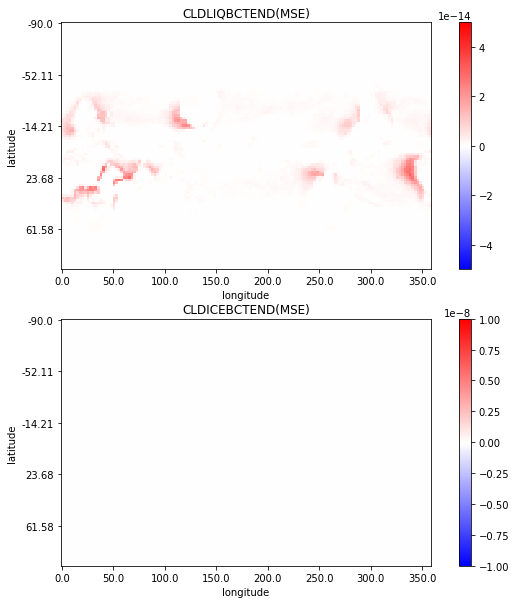

In [29]:
for nn in NNarray:
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,1,figsize=(10, 10))
    axarr = axarr.flatten()
    vmins = [-5e-14,-1e-8,-3e-16,-2e-17]
    vmaxs = [5e-14,1e-8,3e-16,2e-17]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow(mdx.stats['mse'][:,:,(i+1)*25],cmap=plt.cm.bwr,vmin=vmins[i],vmax=vmaxs[i])
        axarr[i].set_xlabel("longitude")
        axarr[i].set_ylabel("latitude")
        axarr[i].set_title(f"{t}(MSE)")
        axarr[i].set_xticks(np.arange(0,141,20))
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticklabels(x_ticks)
        axarr[i].set_yticks(np.arange(0,81,20))
        axarr[i].set_yticklabels(y_ticks)
    plt.show()

RH_RG_TrimTuned_PartialOP_V1.h5


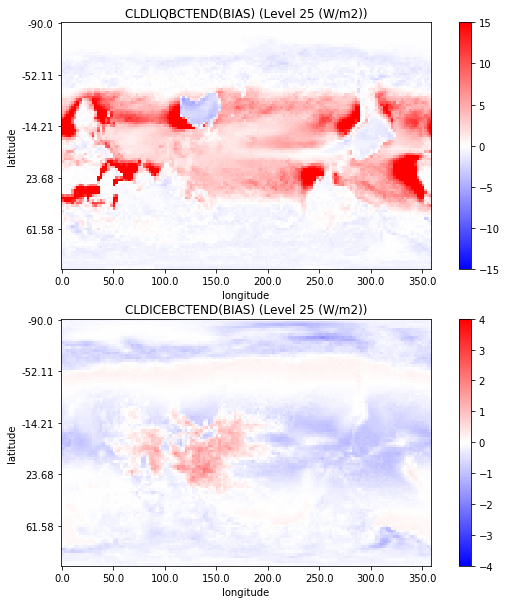

In [30]:
for j, nn in enumerate(NNarray):
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,1,figsize=(10, 10))
    axarr = axarr.flatten()
#     vmins = [-1.0e-7,-0.00003,-4e-9,-1.5e-9]
#     vmaxs = [1.0e-7,0.00003,4e-9,1.5e-9]
    vmins = [-15,-4,-1,-0.4]
    vmaxs = [15,4,1,0.4]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow(mdx.stats['bias'][:,:,(i+1)*25]*fd[j][t][-1],cmap=plt.cm.bwr,vmin=vmins[i],vmax=vmaxs[i])
        axarr[i].set_xlabel("longitude")
        axarr[i].set_ylabel("latitude")
        axarr[i].set_title(f"{t}(BIAS) (Level 25 (W/m2))")
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticks(np.arange(0,141,20))
        axarr[i].set_xticklabels(x_ticks)
        axarr[i].set_yticks(np.arange(0,81,20))
        axarr[i].set_yticklabels(y_ticks)
    plt.show()


In [ ]:
for j, nn in enumerate(NNarray):
    print(nn)
    mdx = md[nn][data_file[0][6:-3]]
    ilev = 25
    y_ticks = lat.values[np.arange(0,81,20)]
    y_ticks = np.around(y_ticks,decimals=2)
    x_ticks = lon.values[np.arange(0,141,20)]
    f, axarr = plt.subplots(2,1,figsize=(1, 15))
    axarr = axarr.flatten()
    lon_mean = np.mean(mdx.stats['bias'],axis=1)
#     vmins = [-1.5e-8,-0.5e-5,-0.4e-9,-6e-10]
#     vmaxs = [1.5e-8,0.5e-5,0.4e-9,6e-10]
    vmins = [-5,-1,-0.5,-0.2]
    vmaxs = [5,1,0.5,0.2]
    for i,t in enumerate(tendencies):
        im = axarr[i].imshow((lon_mean[:,i*26:(i+1)*26]*fd[j][t]).T,cmap=plt.cm.bwr,vmax=vmaxs[i],vmin=vmins[i])
        axarr[i].set_xlabel("Latitude")
        axarr[i].set_ylabel("Level")
        axarr[i].set_title(f"{t}(BIAS)(W/m2)")
        f.colorbar(im,ax=axarr[i])
        axarr[i].set_xticks(np.arange(0,81,20))
        axarr[i].set_xticklabels(y_ticks)
    plt.show()